In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregar os dados
data = pd.read_csv('./data/indexProcessed.csv')

# Pré-processamento dos dados
prices = data['Close'].values.astype(float)
prices = prices.reshape(-1, 1)  # Reshape para (n_samples, 1)

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_normalized = scaler.fit_transform(prices)

In [3]:
# Dividir os dados em sequências de entrada e saída
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return sequences

seq_length = 10
sequences = create_sequences(prices_normalized, seq_length)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(sequences))
train_data = sequences[:split]
test_data = sequences[split:]

In [4]:
# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 32
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Definir a função de perda e otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Treinar o modelo
num_epochs = 20
for epoch in range(num_epochs):
    for seq, labels in train_data:
        seq = torch.FloatTensor(seq).unsqueeze(0)
        labels = torch.FloatTensor(labels)
        
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}ß')

/opt/anaconda3/envs/prof2/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 4.518412606557831e-05ß
Epoch [2/20], Loss: 2.1341240426409058e-05ß
Epoch [3/20], Loss: 7.205280780908652e-06ß
Epoch [4/20], Loss: 3.7408772186608985e-05ß
Epoch [5/20], Loss: 3.8076679629739374e-05ß
Epoch [6/20], Loss: 3.504808046272956e-05ß
Epoch [7/20], Loss: 2.9843762604286894e-05ß
Epoch [8/20], Loss: 3.106867734459229e-05ß
Epoch [9/20], Loss: 3.1230683816829696e-05ß
Epoch [10/20], Loss: 3.472033131401986e-05ß
Epoch [11/20], Loss: 2.99617531709373e-05ß
Epoch [12/20], Loss: 2.7714237148757093e-05ß
Epoch [13/20], Loss: 2.7975920602330007e-05ß
Epoch [14/20], Loss: 2.733523433562368e-05ß
Epoch [15/20], Loss: 2.6886471459874883e-05ß
Epoch [16/20], Loss: 2.5971225113607943e-05ß
Epoch [17/20], Loss: 2.530875826778356e-05ß
Epoch [18/20], Loss: 2.4616389055154286e-05ß
Epoch [19/20], Loss: 2.3983804567251354e-05ß
Epoch [20/20], Loss: 2.3417103875544854e-05ß


In [6]:
# Avaliar o modelo
model.eval()
predictions = []
with torch.no_grad():
    for seq, _ in test_data:
        seq = torch.FloatTensor(seq).unsqueeze(0)
        pred = model(seq).item()
        predictions.append(pred)

# Desnormalizar as previsões
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

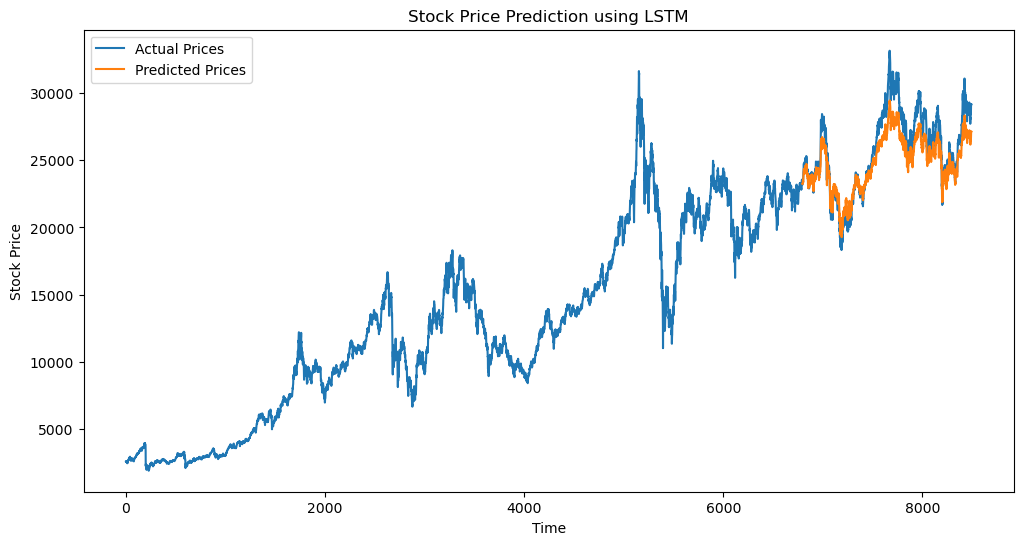

In [7]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].values, label='Actual Prices')
plt.plot(np.arange(split+seq_length, len(data['Close'])), predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()